In [104]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(patchwork))

library(plyr)
library(ggbeeswarm)
library(rstatix)
library(ggpubr)
library(ggplot2)

In [105]:
df<-read.csv("02_Flow_scRNA_Frequency_Comparison/Flow_Frequency_CD27neg_effector_B_Isotye.csv")

In [106]:
df <- df %>%
  mutate(`Age Group` = case_when(
    startsWith(donor, "BR1") ~ 'Young',
    TRUE ~ 'Older'
  ))

In [107]:
df<-df %>% mutate(Flu_Day=case_when(timepoint=="day0"~"Day 0", TRUE~"Day 7"))

df$`Age Group`<-factor(df$`Age Group`,levels=c("Young","Older"))

In [108]:
df<-df %>%filter(Isotype=='IgG')

Warning message in geom_point(alpha = 1, size = 0.8, width = 0.3):
“Ignoring unknown parameters: `width`”
Warning message in stat_summary(fun = "median", aes(fill = "Median"), geom = "crossbar", :
“Ignoring unknown parameters: `shape`”


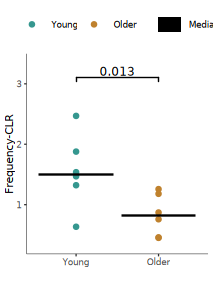

In [115]:
options(repr.plot.width = 45/25.4, repr.plot.height = 60/25.4)

p1<-ggplot(df %>% filter(timepoint=='day0'), aes(`Age Group`, frequency_clr, color=`Age Group`)) + 
geom_point(alpha=1.0, size=0.8, width=0.3) +
stat_summary(fun="median", aes(fill="Median"),geom="crossbar", shape=18, size=0.2, 
           color='black', na.rm=T) + 
theme_classic(base_size=6) +
stat_compare_means( label = "p.format",method='wilcox.test',paired=FALSE,size=2.5,  
                   label.y=3,method.args = list(alternative = "greater"),
  comparisons = list(c("Young", "Older")))+
scale_fill_manual(values="black", name="") + 
xlab("") +
scale_color_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
scale_y_continuous(limits = c(NA, NA),
               expand = expansion(mult = c(0.1, 0.15)))+
xlab('')+
ylab('Frequency-CLR')+theme(
panel.border = element_blank())   +
theme(axis.line = element_line(colour = "black", linewidth = 0.1),
  legend.position = "top",
  legend.title = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  strip.background = element_rect(linewidth = 0),
  axis.title.x = element_text(margin = margin(t = 1)))+
  theme(plot.title = element_text(hjust = 0.5))
p1

Warning message in geom_point(alpha = 1, size = 0.8, width = 0.3):
“Ignoring unknown parameters: `width`”
Warning message in stat_summary(fun = "median", aes(fill = "Median"), geom = "crossbar", :
“Ignoring unknown parameters: `shape`”


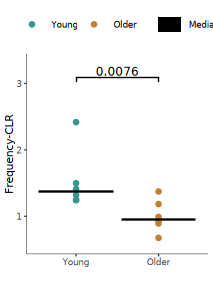

In [116]:
options(repr.plot.width = 45/25.4, repr.plot.height = 60/25.4)

p2<-ggplot(df %>% filter(timepoint=='day7'), aes(`Age Group`, frequency_clr, color=`Age Group`)) + 
geom_point(alpha=1.0, size=0.8, width=0.3) +
stat_summary(fun="median", aes(fill="Median"),geom="crossbar", shape=18, size=0.2, 
           color='black', na.rm=T) + 
theme_classic(base_size=6) +
stat_compare_means( label = "p.format",method='wilcox.test',paired=FALSE,size=2.5,  
                   label.y=3,method.args = list(alternative = "greater"),
  comparisons = list(c("Young", "Older")))+
scale_fill_manual(values="black", name="") + 
xlab("") +
scale_color_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
scale_y_continuous(limits = c(NA, NA),
               expand = expansion(mult = c(0.1, 0.15)))+
xlab('')+
ylab('Frequency-CLR')+theme(
panel.border = element_blank())   +
theme(axis.line = element_line(colour = "black", linewidth = 0.1),
  legend.position = "top",
  legend.title = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  strip.background = element_rect(linewidth = 0),
  axis.title.x = element_text(margin = margin(t = 1)))+
  theme(plot.title = element_text(hjust = 0.5))
p2

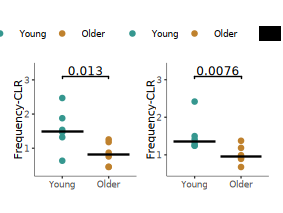

In [117]:
options(repr.plot.width = 60/25.4, repr.plot.height = 45/25.4)

p<-p1+p2
p
ggsave('FigureG.pdf',p,width = 60/25.4,height = 45/25.4)